In [1]:
import os
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import transforms, utils
from torch.utils.data import DataLoader, TensorDataset

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2


from datasets_local import gaussian_mixture

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda:2


In [2]:

from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
vocab_size = 2
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (1, 28, 28)
num_timesteps = 100

p_ref = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
p_ref.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256_copy.pth'))
p_ref.eval()

MaskedDiffusion(
  (denoising_model): UNetWithAttention(
    (embedding): Embedding(3, 64)
    (time_embedding): SinusoidalPosEmb()
    (temb_mlp): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): NonLinearity()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NonLinearity()
    )
    (initial_block): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): ResNetBlock(
          (norm1): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin1): NonLinearity()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin2): NonLinearity()
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), str

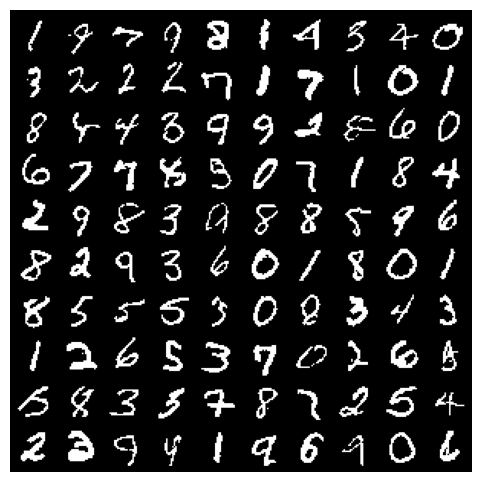

In [3]:
# Visualize samples from the pretrained model
with torch.no_grad():
    samples = p_ref.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [4]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch
mnist_classfier_model = BinarizedMNISTClassifier().to(device)
mnist_classfier_model.load_state_dict(torch.load('../model_weights/binarized_mnist_classifier_1_copy.pth'))

def compute_rewards_for_batch(x: Tensor, with_grad=False):
    # x.shape : (B, 1, 28, 28, num_categories)
    logits = mnist_classfier_model(x[..., :vocab_size].to(device)) # Shape: (B, 10)
    logits = logits.log_softmax(dim=-1) # Shape: (B, 10)
    reward = logits[:, 4]
    return reward

def compute_rewards(x, with_grad=False):
    n_samples = x.shape[0]
    rewards_all = []
    for i in range(0, n_samples, batch_size):
        if with_grad:
            rewards = compute_rewards_for_batch(x[i:i + batch_size])
        else:
            with torch.no_grad():
                rewards = compute_rewards_for_batch(x[i:i + batch_size])
        rewards_all.append(rewards)
    rewards_all = torch.cat(rewards_all)
    return rewards_all

kl_weight = 1.0

def compute_rewards_with_kl_weight(*args, **kwargs):
    rewards = compute_rewards(*args, **kwargs)
    return rewards / kl_weight

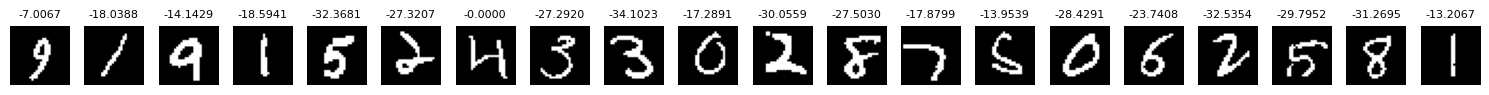

In [5]:
# Visualize rewards
from datasets_local.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=20)
samples, _ = next(iter(train_loader))
rewards = compute_rewards(F.one_hot(samples.long(), num_classes=num_categories).float())

fig, axes = plt.subplots(1, 20, figsize=(15, 2))
for i in range(20):
    ax = axes[i]
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.set_title(f"{rewards[i].item():.4f}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

Visualize target dist

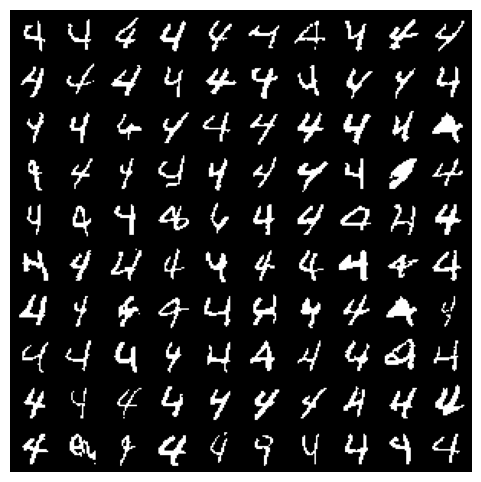

Target Reward: -0.05571801960468292
Diversity: 96


In [6]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    dataset = torch.load("../datasets_local/pretrained_mnist_samples_dataset.pt", weights_only=False)
    train_loader = DataLoader(dataset, batch_size)
    log_pdf_values = []
    for samples, _ in train_loader:
        samples = samples.long()
        log_pdf_values.append(target_distribution_log_pdf(samples, kl_weight))
    log_pdf_values = torch.cat(log_pdf_values, dim=0)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return torch.stack([train_loader.dataset[i][0].long() for i in indices])

target_samples = sample_target_distribution(100, kl_weight)

grid = utils.make_grid(target_samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().float().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

target_rewards = compute_rewards(
    F.one_hot(target_samples, num_classes=num_categories).float()
)
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {torch.unique(target_samples, dim=0).shape[0]}")

In [7]:
@torch.no_grad()
def estimate_reward(probs, num_samples, method='mean'):
    B = probs.shape[0]
    dist = torch.distributions.Categorical(probs=probs)
    samples = dist.sample((num_samples,)).reshape(num_samples * B, *input_shape)
    rewards = compute_rewards_with_kl_weight(F.one_hot(samples, num_classes=num_categories).float()).reshape(num_samples, B)
    if method == 'mean':
        return rewards.mean(dim=0) # E[r(x)/alpha]
    elif method == 'logmeanexp':
        return rewards.logsumexp(dim=0) - math.log(num_samples) # log E[exp(r(x)/alpha)]
    else:
        raise ValueError(f"Unknown method: {method}")

In [8]:
q_phi = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
q_phi.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256_copy.pth'))
q_phi.eval()

f_psi = torch.nn.Parameter(torch.zeros(q_phi.num_timesteps, device=device))

In [9]:
batch_size = 32
lr = 0.0001
optimizer = torch.optim.Adam(list(q_phi.parameters()) + [f_psi], lr=lr)
num_epochs = 100
batches_per_epoch = 5
patience = 5
sample_onpolicy = True
num_samples_for_reward_estimate = 10
reward_estimate_method = 'logmeanexp'
timesteps_for_loss = 10

model_save_dir = '../model_weights/log_variance_loss'
os.makedirs(model_save_dir, exist_ok=True)
ckpt_path = f'{model_save_dir}/binarized_mnist.pth'

In [10]:
loss_trace = []
reward_trace = []

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:25<01:42, 25.59s/it]

Batch idx: 0, Loss: 27.074697494506836


 40%|████      | 2/5 [00:51<01:16, 25.52s/it]

Batch idx: 1, Loss: 29.59905433654785


 60%|██████    | 3/5 [01:16<00:50, 25.50s/it]

Batch idx: 2, Loss: 27.917186737060547


 80%|████████  | 4/5 [01:42<00:25, 25.49s/it]

Batch idx: 3, Loss: 19.534961700439453


100%|██████████| 5/5 [02:07<00:00, 25.50s/it]

Batch idx: 4, Loss: 21.76426124572754
Epoch 1/100,  Loss: 25.178032302856444


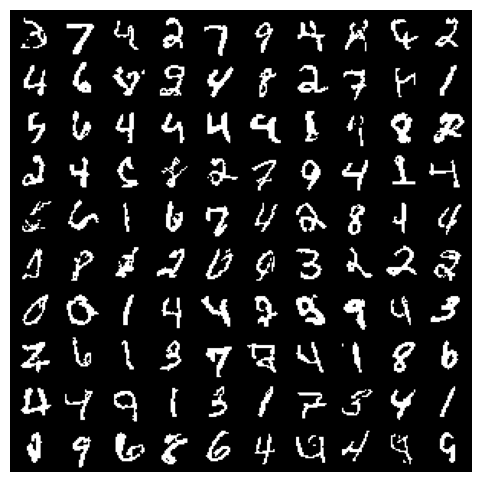

Reward: -11.794699668884277
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.47s/it]

Batch idx: 0, Loss: 20.814260482788086


 40%|████      | 2/5 [00:50<01:16, 25.48s/it]

Batch idx: 1, Loss: 22.68248748779297


 60%|██████    | 3/5 [01:16<00:50, 25.48s/it]

Batch idx: 2, Loss: 10.065468788146973


 80%|████████  | 4/5 [01:41<00:25, 25.49s/it]

Batch idx: 3, Loss: 26.96689796447754


100%|██████████| 5/5 [02:07<00:00, 25.48s/it]

Batch idx: 4, Loss: 16.201152801513672
Epoch 2/100,  Loss: 19.346053504943846


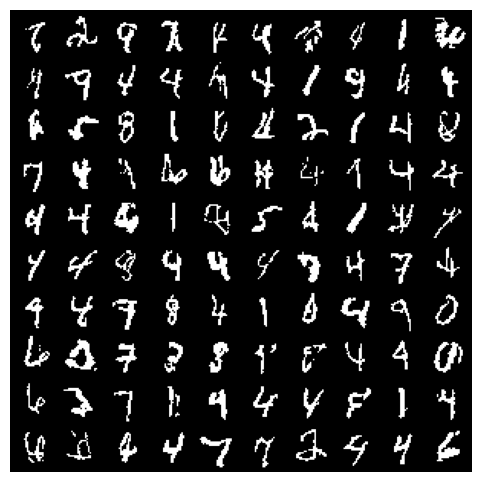

Reward: -6.97667121887207
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.48s/it]

Batch idx: 0, Loss: 12.171775817871094


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 19.749393463134766


 60%|██████    | 3/5 [01:16<00:50, 25.47s/it]

Batch idx: 2, Loss: 9.466081619262695


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 26.39164161682129


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 35.78070068359375
Epoch 3/100,  Loss: 20.71191864013672


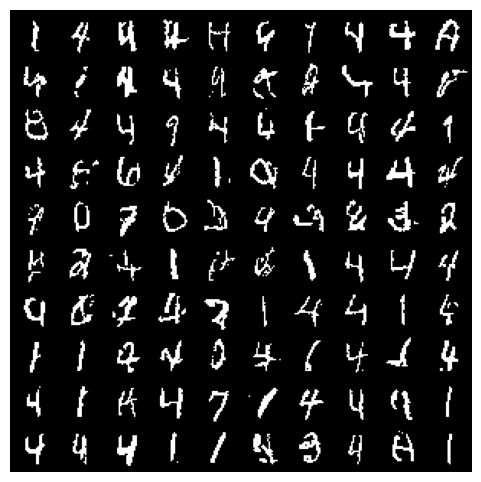

Reward: -5.396402359008789


 20%|██        | 1/5 [00:25<01:41, 25.46s/it]

Batch idx: 0, Loss: 9.216435432434082


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 14.440662384033203


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 11.656364440917969


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 19.691152572631836


100%|██████████| 5/5 [02:07<00:00, 25.46s/it]

Batch idx: 4, Loss: 15.927170753479004
Epoch 4/100,  Loss: 14.186357116699218


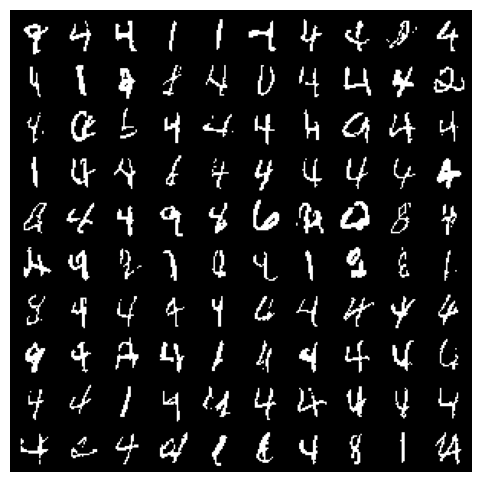

Reward: -3.682912588119507
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.46s/it]

Batch idx: 0, Loss: 12.363353729248047


 40%|████      | 2/5 [00:50<01:16, 25.46s/it]

Batch idx: 1, Loss: 1.9801884889602661


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 8.257431983947754


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 10.703587532043457


100%|██████████| 5/5 [02:07<00:00, 25.46s/it]

Batch idx: 4, Loss: 10.120193481445312
Epoch 5/100,  Loss: 8.684951043128967


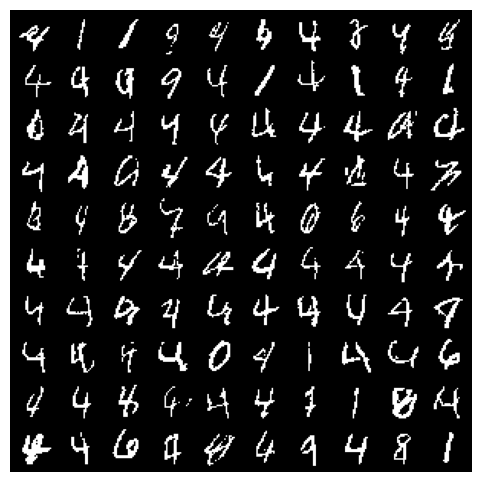

Reward: -3.8202900886535645
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.47s/it]

Batch idx: 0, Loss: 8.24866008758545


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 5.144848346710205


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 12.199915885925293


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 14.265610694885254


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 8.812432289123535
Epoch 6/100,  Loss: 9.734293460845947


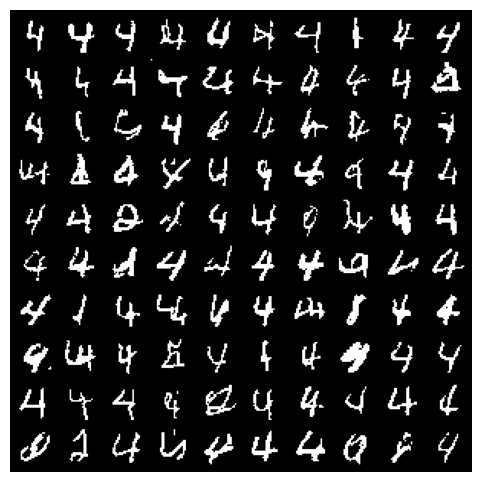

Reward: -1.4457405805587769


 20%|██        | 1/5 [00:25<01:41, 25.46s/it]

Batch idx: 0, Loss: 14.653637886047363


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 6.246391296386719


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 9.214111328125


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 4.187990665435791


100%|██████████| 5/5 [02:07<00:00, 25.46s/it]

Batch idx: 4, Loss: 6.473630905151367
Epoch 7/100,  Loss: 8.155152416229248


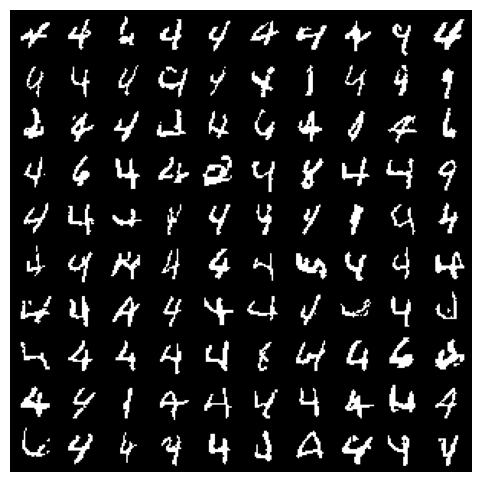

Reward: -1.2733372449874878
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.46s/it]

Batch idx: 0, Loss: 3.0844836235046387


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 8.588186264038086


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 12.459148406982422


 80%|████████  | 4/5 [01:41<00:25, 25.51s/it]

Batch idx: 3, Loss: 3.885673999786377


100%|██████████| 5/5 [02:07<00:00, 25.49s/it]

Batch idx: 4, Loss: 5.491849899291992
Epoch 8/100,  Loss: 6.7018684387207035


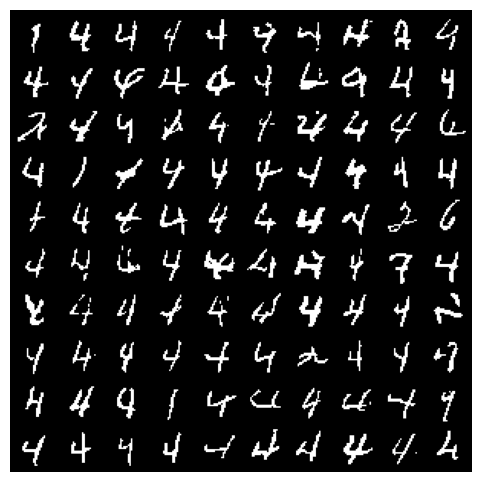

Reward: -1.6817243099212646
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.47s/it]

Batch idx: 0, Loss: 5.14727783203125


 40%|████      | 2/5 [00:50<01:16, 25.46s/it]

Batch idx: 1, Loss: 7.512571334838867


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 2.907289505004883


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 6.4180169105529785


100%|██████████| 5/5 [02:07<00:00, 25.46s/it]

Batch idx: 4, Loss: 3.516355276107788
Epoch 9/100,  Loss: 5.1003021717071535


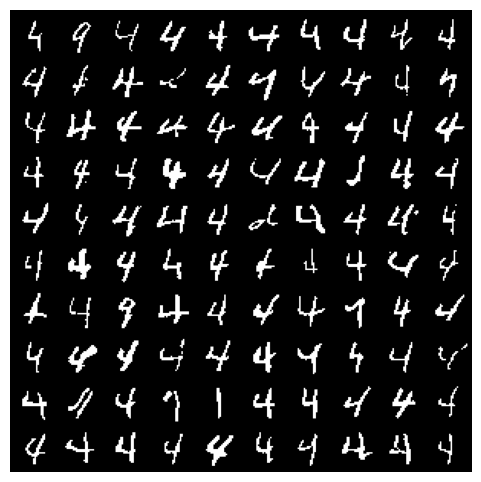

Reward: -0.8331106305122375
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.48s/it]

Batch idx: 0, Loss: 6.191411972045898


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 8.663390159606934


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 4.8745808601379395


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 3.603039026260376


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 1.8880894184112549
Epoch 10/100,  Loss: 5.04410228729248


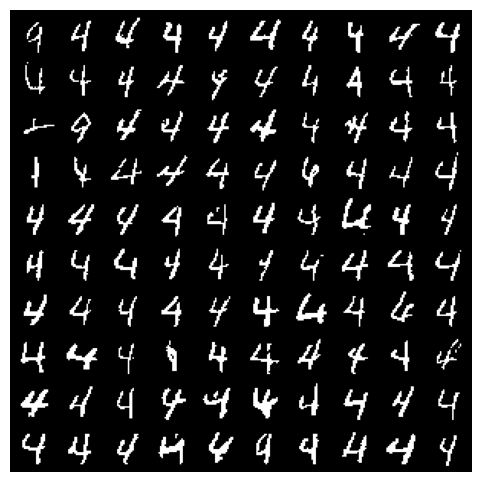

Reward: -0.47548410296440125
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.48s/it]

Batch idx: 0, Loss: 4.656820774078369


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 4.072011947631836


 60%|██████    | 3/5 [01:16<00:50, 25.47s/it]

Batch idx: 2, Loss: 0.5647835731506348


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 2.7186689376831055


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 2.6468770503997803
Epoch 11/100,  Loss: 2.931832456588745


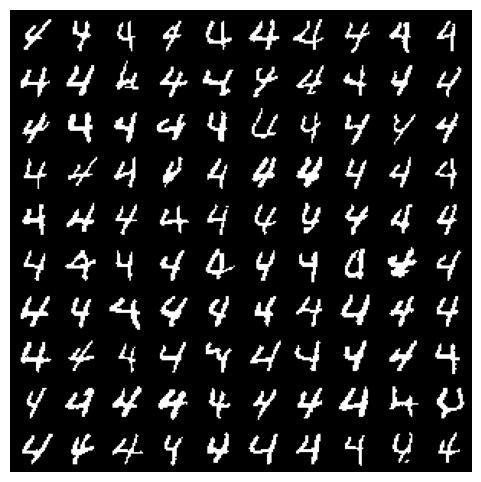

Reward: -0.07026363909244537
Saved model weights.


 20%|██        | 1/5 [00:25<01:42, 25.56s/it]

Batch idx: 0, Loss: 3.3701558113098145


 40%|████      | 2/5 [00:51<01:16, 25.56s/it]

Batch idx: 1, Loss: 2.6377205848693848


 60%|██████    | 3/5 [01:16<00:51, 25.53s/it]

Batch idx: 2, Loss: 4.070871829986572


 80%|████████  | 4/5 [01:42<00:25, 25.55s/it]

Batch idx: 3, Loss: 2.0700085163116455


100%|██████████| 5/5 [02:07<00:00, 25.55s/it]

Batch idx: 4, Loss: 2.3393664360046387
Epoch 12/100,  Loss: 2.897624635696411


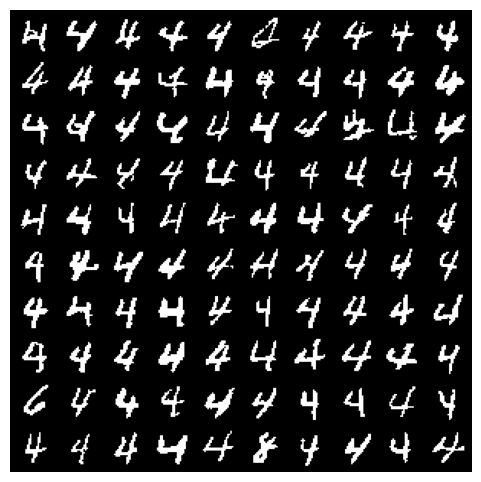

Reward: -0.2927194833755493
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.49s/it]

Batch idx: 0, Loss: 2.77207350730896


 40%|████      | 2/5 [00:50<01:16, 25.48s/it]

Batch idx: 1, Loss: 4.913036346435547


 60%|██████    | 3/5 [01:16<00:50, 25.48s/it]

Batch idx: 2, Loss: 3.751267671585083


 80%|████████  | 4/5 [01:41<00:25, 25.48s/it]

Batch idx: 3, Loss: 4.956174850463867


100%|██████████| 5/5 [02:07<00:00, 25.48s/it]

Batch idx: 4, Loss: 5.221553325653076
Epoch 13/100,  Loss: 4.322821140289307


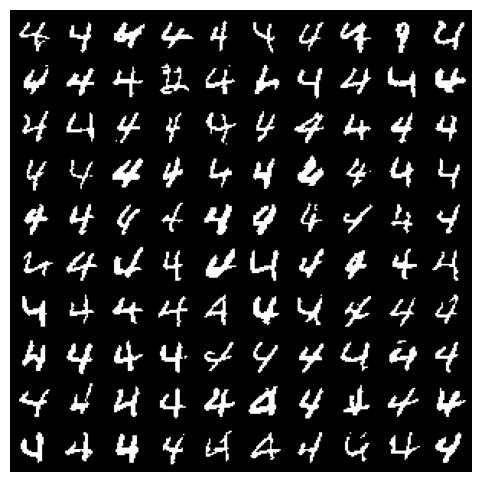

Reward: -0.22577542066574097


 20%|██        | 1/5 [00:25<01:41, 25.50s/it]

Batch idx: 0, Loss: 4.450276851654053


 40%|████      | 2/5 [00:50<01:16, 25.49s/it]

Batch idx: 1, Loss: 6.207667350769043


 60%|██████    | 3/5 [01:16<00:50, 25.48s/it]

Batch idx: 2, Loss: 2.9082322120666504


 80%|████████  | 4/5 [01:41<00:25, 25.48s/it]

Batch idx: 3, Loss: 2.3849494457244873


100%|██████████| 5/5 [02:07<00:00, 25.48s/it]

Batch idx: 4, Loss: 6.7111124992370605
Epoch 14/100,  Loss: 4.532447671890258


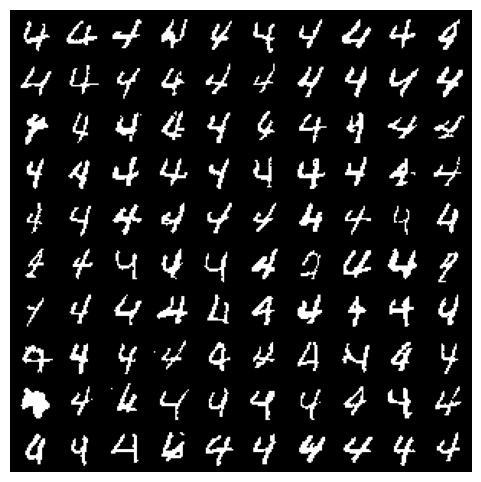

Reward: -0.18349029123783112


 20%|██        | 1/5 [00:25<01:41, 25.48s/it]

Batch idx: 0, Loss: 2.4478297233581543


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 1.9236295223236084


 60%|██████    | 3/5 [01:16<00:50, 25.47s/it]

Batch idx: 2, Loss: 5.05722188949585


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 2.7749907970428467


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 4.480044841766357
Epoch 15/100,  Loss: 3.3367433547973633


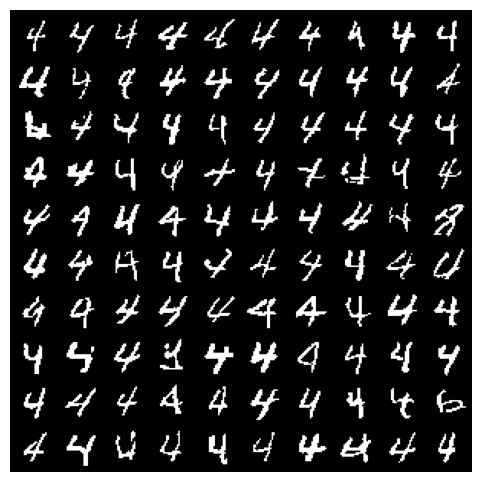

Reward: -0.27025675773620605


 20%|██        | 1/5 [00:25<01:41, 25.47s/it]

Batch idx: 0, Loss: 1.285189151763916


 40%|████      | 2/5 [00:50<01:16, 25.48s/it]

Batch idx: 1, Loss: 2.1589319705963135


 60%|██████    | 3/5 [01:16<00:50, 25.47s/it]

Batch idx: 2, Loss: 4.304585933685303


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 3.6786506175994873


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 1.8104450702667236
Epoch 16/100,  Loss: 2.647560548782349


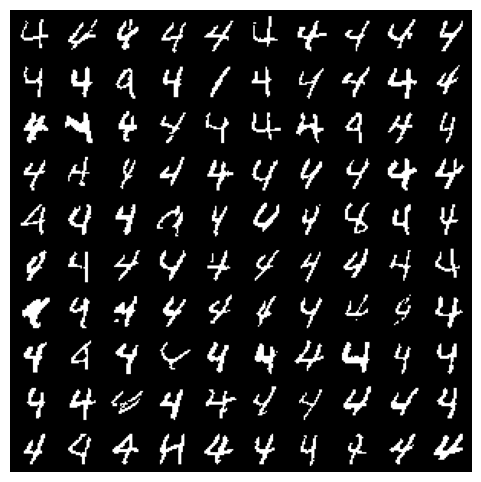

Reward: -0.2967725992202759
Saved model weights.


 20%|██        | 1/5 [00:25<01:41, 25.49s/it]

Batch idx: 0, Loss: 3.0511868000030518


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 5.027783393859863


 60%|██████    | 3/5 [01:16<00:50, 25.48s/it]

Batch idx: 2, Loss: 9.453551292419434


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 3.9373674392700195


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 10.418489456176758
Epoch 17/100,  Loss: 6.3776756763458256


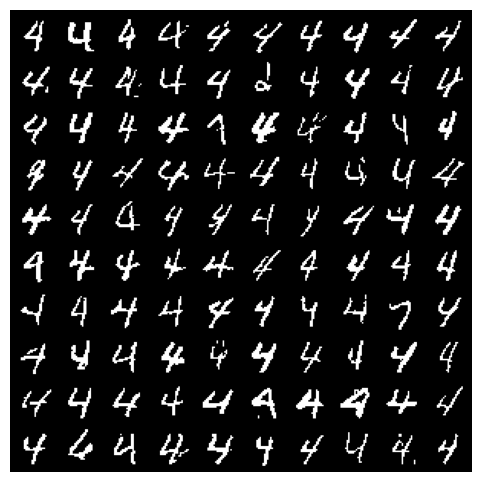

Reward: -0.4595995247364044


 20%|██        | 1/5 [00:25<01:41, 25.48s/it]

Batch idx: 0, Loss: 4.336957931518555


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 1.3478419780731201


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 9.74821949005127


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 4.307372093200684


100%|██████████| 5/5 [02:07<00:00, 25.46s/it]

Batch idx: 4, Loss: 0.8108088374137878
Epoch 18/100,  Loss: 4.1102400660514835


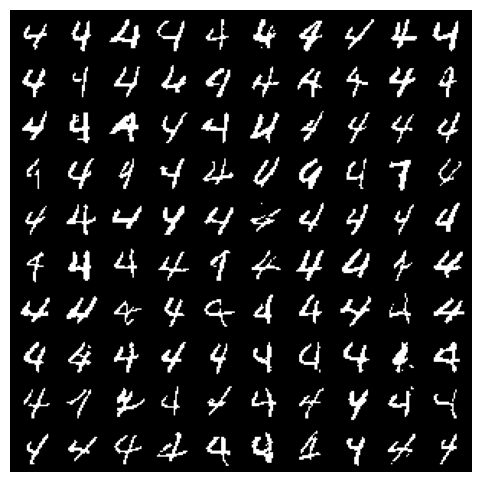

Reward: -0.46761977672576904


 20%|██        | 1/5 [00:25<01:41, 25.48s/it]

Batch idx: 0, Loss: 9.2545747756958


 40%|████      | 2/5 [00:50<01:16, 25.47s/it]

Batch idx: 1, Loss: 3.7525157928466797


 60%|██████    | 3/5 [01:16<00:50, 25.47s/it]

Batch idx: 2, Loss: 1.4493008852005005


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 3.986741781234741


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 2.2823832035064697
Epoch 19/100,  Loss: 4.145103287696839


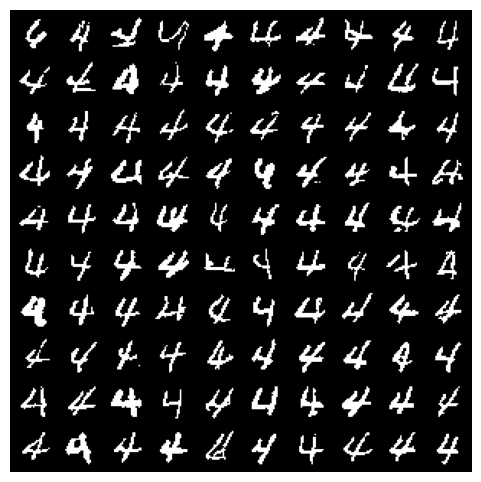

Reward: -0.07097930461168289


 20%|██        | 1/5 [00:25<01:41, 25.47s/it]

Batch idx: 0, Loss: 1.306638240814209


 40%|████      | 2/5 [00:50<01:16, 25.48s/it]

Batch idx: 1, Loss: 3.697157382965088


 60%|██████    | 3/5 [01:16<00:50, 25.47s/it]

Batch idx: 2, Loss: 5.91146993637085


 80%|████████  | 4/5 [01:41<00:25, 25.47s/it]

Batch idx: 3, Loss: 3.4593305587768555


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Batch idx: 4, Loss: 3.786860227584839
Epoch 20/100,  Loss: 3.6322912693023683


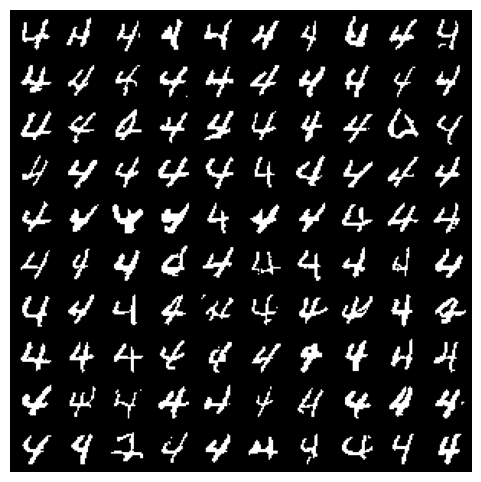

Reward: -0.19516213238239288


 20%|██        | 1/5 [00:25<01:41, 25.45s/it]

Batch idx: 0, Loss: 4.827545166015625


 40%|████      | 2/5 [00:50<01:16, 25.45s/it]

Batch idx: 1, Loss: 7.060847759246826


 60%|██████    | 3/5 [01:16<00:50, 25.46s/it]

Batch idx: 2, Loss: 3.147876501083374


 80%|████████  | 4/5 [01:41<00:25, 25.46s/it]

Batch idx: 3, Loss: 4.976197242736816


100%|██████████| 5/5 [02:07<00:00, 25.46s/it]

Batch idx: 4, Loss: 2.3009557723999023
Epoch 21/100,  Loss: 4.462684488296508


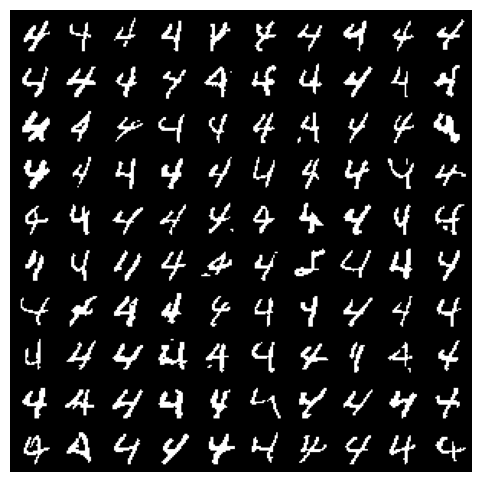

Reward: -0.17312856018543243


In [11]:
L = math.prod(q_phi.input_shape)

# Training loop
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    for batch_idx in tqdm(range(batches_per_epoch)):
        q_phi.train()
        
        rewards_prev = None
        log_prob_p_ref = None
        log_prob_q_phi = None
        loss = torch.tensor(0.0, device=device)
        
        # We select only #timesteps_for_loss timesteps randomly for loss calculation to fit in memory
        is_selected_timestep = torch.zeros(
            q_phi.num_timesteps, dtype=torch.bool
        ).scatter_(0, torch.randperm(q_phi.num_timesteps)[:timesteps_for_loss], True)
        
        # Generate batch_size samples from q_phi
        z_t = torch.full((batch_size, L), q_phi.mask_index, device=device) # Intialize with all masks
        for i in range(q_phi.num_timesteps, 0, -1):
            # Invoke pretrained and finetune models
            with torch.enable_grad() if is_selected_timestep[i-1] else torch.no_grad():
                q_phi_zs_given_zt, q_phi_z0_given_zt = q_phi.sample_step(
                    F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
                )
            with torch.no_grad():
                p_ref_zs_given_zt, p_ref_z0_given_zt = p_ref.sample_step(
                    F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
                )
            # Estimate rewards
            rewards = estimate_reward(p_ref_z0_given_zt, num_samples_for_reward_estimate, method=reward_estimate_method)
            
            if rewards_prev is not None and is_selected_timestep[i]:
                assert log_prob_p_ref is not None and log_prob_q_phi is not None
                
                log_w = (rewards - rewards_prev) + (log_prob_p_ref - log_prob_q_phi) # Shape: (batch-size,)
                log_variance = (log_w - f_psi[i]) ** 2
                loss += log_variance.mean(dim=0) # take mean across batch dimension
            
            q_phi_dist = torch.distributions.Categorical(probs=q_phi_zs_given_zt)
            p_ref_dist = torch.distributions.Categorical(probs=p_ref_zs_given_zt)
            
            if sample_onpolicy:
                z_s = q_phi_dist.sample()
            else:
                z_s = p_ref_dist.sample()
                
            log_prob_q_phi = q_phi_dist.log_prob(z_s).sum(dim=1)
            log_prob_p_ref = p_ref_dist.log_prob(z_s).sum(dim=1)
            
            # Update for next step
            z_t = z_s
            rewards_prev = rewards
            
        z_0 = z_t.reshape(batch_size, *input_shape)
        # Compute rewards
        rewards = compute_rewards_with_kl_weight(F.one_hot(z_0, num_classes=num_categories).float())
        
        if is_selected_timestep[0]:
            assert rewards_prev is not None and log_prob_p_ref is not None and log_prob_q_phi is not None
            log_w = (rewards - rewards_prev) + (log_prob_p_ref - log_prob_q_phi) # Shape: (batch-size,)
            log_variance = (log_w - f_psi[0]) ** 2
            loss += log_variance.mean(dim=0) # take mean across batch dimension
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
        print(f"Batch idx: {batch_idx}, Loss: {loss.item()}")
    
    q_phi.eval()
    avg_loss = total_epoch_loss / batches_per_epoch
    print(f"Epoch {epoch+1}/{num_epochs},  Loss: {avg_loss}")
    loss_trace.append(avg_loss)
    
    with torch.no_grad():
        model_samples = q_phi.sample(num_samples=100, device=device).cpu()
    grid = utils.make_grid(model_samples.float(), nrow=10, padding=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
    plt.axis('off')
    plt.show()
    
    rewards = compute_rewards(F.one_hot(model_samples, num_classes=num_categories).float())
    print(f"Reward: {rewards.mean().item()}")
    reward_trace.append(rewards.mean().item())
    
    if loss_trace[-1] == min(loss_trace):
        # store model weights
        torch.save(q_phi.state_dict(), ckpt_path)
        print("Saved model weights.")
        
    if min(loss_trace) < min(loss_trace[-patience:]):
        break
    

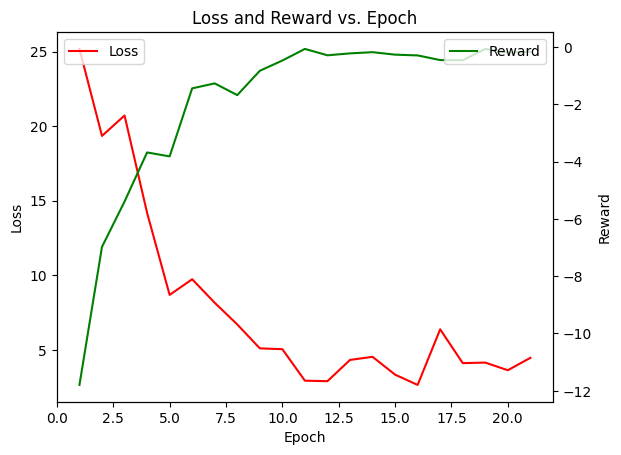

In [13]:
import matplotlib.pyplot as plt

# loss_trace and reward_trace are 1D lists (or 1D arrays) of the same length
epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.show()

Visualize samples from the finetuned model

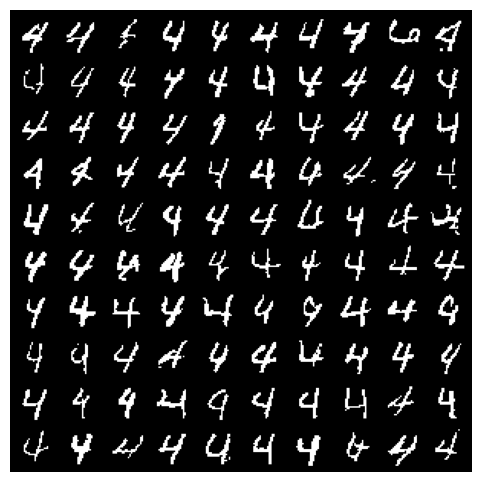

In [14]:
# Load best checkpoint
q_phi.load_state_dict(torch.load(ckpt_path))
q_phi.eval()

with torch.no_grad():
    samples = q_phi.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()